# Thoughts:

When I started writing this notebook, I was trying to show 'how much angle' a feature has in hidden space as you cram more features into an N-dimensional hidden space.

I originally thought, like in 2D, that if a vector's nearest neighbor is an angle $\theta$ away, then that vector has $2\theta$ angular space (because it has that angle in each direction). 

I wasn't accounting for the fact that, in 3D, the vector has a *cone* of space characterized by angle $\theta$, and in 4D, the vector has a [*hypercone*](https://en.wikipedia.org/wiki/Hypercone) of space characterized by that angle. That's how it fits so many vectors in higher dimensional space.

I'm still disturbed by the fact that all vectors are the same magnitude in hiden space. This means that the model is filling a hypersphere evenly, but as the number of dimensions becomes very large, the volume of a hypersphere becomes very small compared to the volume of the whole space!

In [24]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch as t
import einops

from sae_lens.training.toy_models import Config, ReluOutputModel


In [92]:
def get_cossim_matrix(model):
    W_norm = model.W[:,:] / t.norm(model.W[:,:], dim=1, keepdim=True)
    cossim = einops.einsum(W_norm, W_norm, 'inst n_hid n_feat1, inst n_hid n_feat2 -> inst n_feat1 n_feat2')
    return np.array(cossim.detach())

def get_feature_angle_and_expect(model):
    angles = np.arccos(get_cossim_matrix(model))
    angles[np.isnan(angles)] = 0
    # angles[angles > np.pi/2] = angles[angles > np.pi/2] - np.pi
    #Mask zero values and get min(abs()) along first dimension of masked tensor
    masked = np.ma.MaskedArray(angles, angles == 0)
    min_angle = np.min(np.abs(masked), axis=1)

    return angles, min_angle, min_angle / (2*(model.cfg.n_hidden-1)*np.pi/model.cfg.n_features)


# 5 features in 2D

Training Toy Model: 100%|██████████| 10000/10000 [00:02<00:00, 3582.29it/s, loss=0.000243, lr=0.001]
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_70829/3080193257.py:7: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(get_cossim_matrix(model))


torch.Size([1, 2, 5])
min angle [1.2492032051086426 0.0009765625 0.0006905339541845024 1.2600131034851074
 1.2458114624023438]
frac expected [0.9940842986106873 0.0007771237287670374 0.0005495094228535891
 1.0026865005493164 0.9913852214813232]


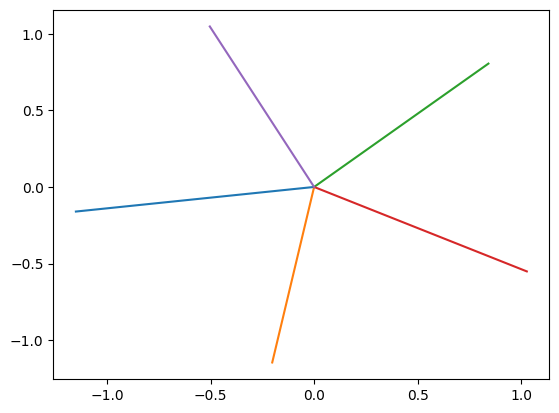

In [72]:
cfg = Config(
        n_instances=1,
        n_features=5,
        n_hidden=2,
    )

model = ReluOutputModel(cfg, feature_probability=0.01)
model.optimize()

print(model.W.shape)
xy = np.zeros((cfg.n_features, 2, 2))
xy[:,1,:] = model.W[0,:,:].detach().numpy().T
for i in range(cfg.n_features):
    plt.plot(xy[i,:,0], xy[i,:,1], label=f'feature {i}')

angles, min_angle, fraction_expected = get_feature_angle_and_expect(model)
print('min angle', min_angle)
print('frac expected', fraction_expected)

# 7+ features in 3D

Training Toy Model: 100%|██████████| 10000/10000 [00:13<00:00, 753.47it/s, loss=0.00109, lr=0.001]

min angle [[2.1714611053466797 2.196986436843872 2.188296318054199
  2.1805882453918457 2.1714611053466797 2.190592050552368
  2.189180612564087 2.189180612564087 2.185983180999756
  2.1915454864501953 2.193676471710205 2.188296318054199
  2.1903250217437744 2.195526123046875]]
frac expected [[2.419191360473633 2.4476287364959717 2.4379472732543945
  2.4293596744537354 2.419191360473633 2.440504789352417
  2.438932418823242 2.438932418823242 2.4353702068328857
  2.4415669441223145 2.443941116333008 2.4379472732543945
  2.4402072429656982 2.4460017681121826]]
mangitudes [[1.2541652 1.0058863 1.2384526 1.2509241 1.2548838 1.0180858 1.01883
  1.2516085 1.2503779 1.2663786 1.2555262 1.0096179 1.2370921 1.2629533]]



/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_70829/4289350771.py:7: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(get_cossim_matrix(model))


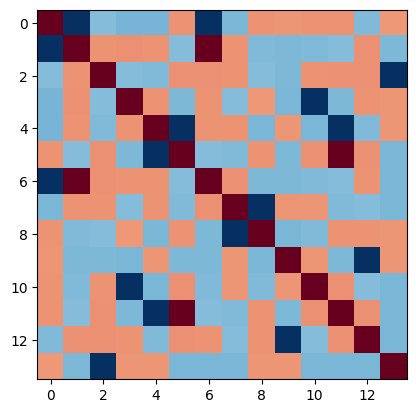

In [107]:
cfg = Config(
        n_instances=1,
        n_features=14,
        n_hidden=3,
    )

model = ReluOutputModel(cfg, feature_probability=0.01)
model.optimize(steps=10_000, batch_size=10_000)

for i in range(cfg.n_instances):
    plt.figure()
    cossim = get_cossim_matrix(model)[i]
    plt.imshow(cossim, cmap='RdBu_r')

angles, min_angle, fraction_expected = get_feature_angle_and_expect(model)
print('min angle', min_angle)
print('frac expected', fraction_expected)
print('mangitudes', t.norm(model.W[:,:,:], dim=1).detach().numpy())

In [105]:
print(2*angles[0,0,:])
print(2*angles[0,:,0])

[ 0.        -3.0269864 -2.7694104 -2.771995   1.8792526  1.8764794
 -2.7140667 -0.8862128 -2.1584072  2.05605   -2.8115275  1.7600127
 -1.3881111  2.0775836 -1.1991615]
[ 0.        -3.0269864 -2.7694104 -2.771995   1.8792526  1.8764794
 -2.7140667 -0.8862128 -2.1584072  2.05605   -2.8115275  1.7600127
 -1.3881111  2.0775836 -1.1991615]


# 20+ features in 5D

Training Toy Model: 100%|██████████| 10000/10000 [00:40<00:00, 247.09it/s, loss=0.00145, lr=0.001]
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_70829/4289350771.py:7: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(get_cossim_matrix(model))


min angle [[0.7736916542053223 0.8439040184020996 0.9349331855773926
  0.7736916542053223 0.9698910713195801 0.3489494323730469
  0.7475290298461914 0.9941754341125488 0.5200338363647461
  1.1789755821228027 1.277122974395752 0.9253144264221191
  0.9941754341125488 1.0251140594482422 1.0122971534729004
  0.8439040184020996 0.5200338363647461 1.0328993797302246
  0.9698910713195801 1.0369634628295898 1.2685680389404297
  1.1854476928710938 0.9989523887634277 0.7475290298461914
  1.2413616180419922 1.0122971534729004 0.9892921447753906
  0.9892921447753906 0.9349331855773926 0.9989523887634277
  1.0280647277832031 0.2871875762939453 0.3489494323730469
  1.2118477821350098 0.2199406623840332 0.9253144264221191
  1.0150055885314941 1.071721076965332 0.2199406623840332
  0.2871875762939453]]
frac expected [[1.2313684225082397 1.343114972114563 1.487992286682129
  1.2313684225082397 1.54362952709198 0.5553702712059021
  1.1897293329238892 1.5822793245315552 0.827659547328949
  1.876397848129

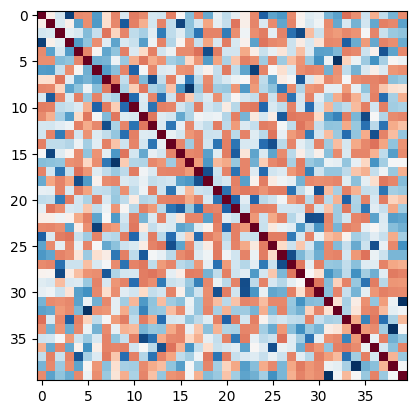

In [110]:
cfg = Config(
        n_instances=1,
        n_features=40,
        n_hidden=5,
    )

model = ReluOutputModel(cfg, feature_probability=0.01)
model.optimize(steps=10_000, batch_size=10_000)

for i in range(cfg.n_instances):
    plt.figure()
    cossim = get_cossim_matrix(model)[i]
    plt.imshow(cossim, cmap='RdBu_r')

angles, min_angle, fraction_expected = get_feature_angle_and_expect(model)
print('min angle', min_angle)
print('frac expected', fraction_expected)
magnitudes = t.norm(model.W[:,:,:], dim=1).detach().numpy()
print('mangitudes', magnitudes.max(), magnitudes.min())

# 50+ features in 10D

Training Toy Model: 100%|██████████| 10000/10000 [00:47<00:00, 211.02it/s, loss=0.000466, lr=0.001]

min angle [[1.7132487297058105 2.0254268646240234 1.9508166313171387
  2.077758312225342 1.9802436828613281 1.8895950317382812
  2.0298871994018555 2.0144314765930176 1.9830174446105957
  1.9573783874511719 1.9078407287597656 2.050663948059082
  2.005255699157715 1.9597978591918945 1.9525909423828125
  1.9929251670837402 2.0647902488708496 1.9697351455688477
  1.8638782501220703 1.8573522567749023 1.9508166313171387
  2.0298871994018555 2.040163040161133 1.9114665985107422
  2.0266942977905273 1.8863296508789062 1.9573783874511719
  1.8638782501220703 1.9593548774719238 1.9525909423828125
  1.956772804260254 1.9924201965332031 1.9679880142211914
  1.9856557846069336 1.8895950317382812 1.9802436828613281
  1.88816499710083 1.9593548774719238 2.0385546684265137
  2.069218158721924 1.9828829765319824 2.0397043228149414
  1.9078407287597656 1.7132487297058105 1.9679880142211914
  1.8523893356323242 2.053882598876953 1.9998083114624023
  1.9697351455688477 1.932631015777588]]
frac expected 


/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_70829/4289350771.py:7: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(get_cossim_matrix(model))


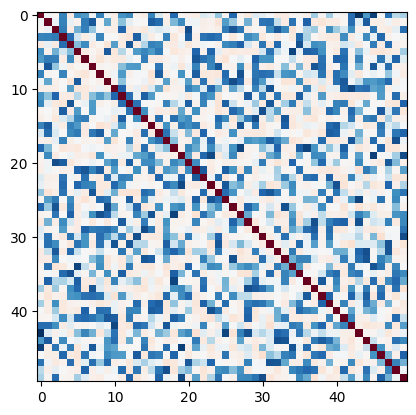

In [113]:
cfg = Config(
        n_instances=1,
        n_features=50,
        n_hidden=10,
    )

model = ReluOutputModel(cfg, feature_probability=0.01)
model.optimize(steps=10_000, batch_size=10_000)

for i in range(cfg.n_instances):
    plt.figure()
    cossim = get_cossim_matrix(model)[i]
    plt.imshow(cossim, cmap='RdBu_r')

angles, min_angle, fraction_expected = get_feature_angle_and_expect(model)
print('min angle', min_angle)
print('frac expected', fraction_expected)
magnitudes = t.norm(model.W[:,:,:], dim=1).detach().numpy()
print('mangitudes', magnitudes.max(), magnitudes.min())

# 500+ features in 50D

Training Toy Model: 100%|██████████| 10000/10000 [09:33<00:00, 17.42it/s, loss=0.000919, lr=0.001]
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_70829/4289350771.py:7: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(get_cossim_matrix(model))


min angle [[2.3068459033966064 2.435065507888794 2.403531074523926
  2.4563100337982178 2.414820909500122 2.4023513793945312
  2.3861093521118164 2.3636035919189453 2.4087002277374268
  2.3342201709747314 2.38716459274292 2.4533464908599854
  2.4877755641937256 2.428388833999634 2.4150283336639404
  2.3615453243255615 2.4257092475891113 2.3068459033966064
  2.430138349533081 2.448329210281372 2.391637086868286
  2.4294190406799316 2.44887113571167 2.371488094329834
  2.4250264167785645 2.4157564640045166 2.3679704666137695
  2.380537986755371 2.424006700515747 2.4247071743011475
  2.3623158931732178 2.376412868499756 2.4314284324645996
  2.4341700077056885 2.3713200092315674 2.4038431644439697
  2.374908447265625 2.3823609352111816 2.378530740737915
  2.408999443054199 2.4256136417388916 2.328488826751709
  2.4553983211517334 2.3416731357574463 2.4610416889190674
  2.4007749557495117 2.3594863414764404 2.4591405391693115
  2.4082601070404053 2.411632537841797 2.4524831771850586
  2.464

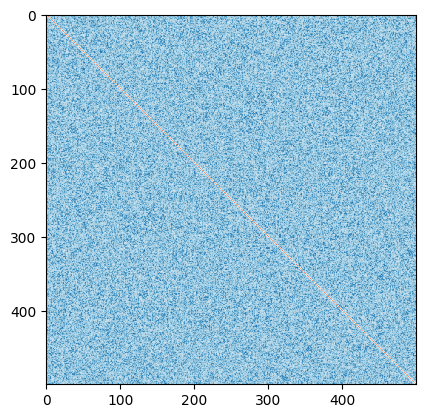

In [114]:
cfg = Config(
        n_instances=1,
        n_features=500,
        n_hidden=50,
    )

model = ReluOutputModel(cfg, feature_probability=0.01)
model.optimize(steps=10_000, batch_size=10_000)

for i in range(cfg.n_instances):
    plt.figure()
    cossim = get_cossim_matrix(model)[i]
    plt.imshow(cossim, cmap='RdBu_r')

angles, min_angle, fraction_expected = get_feature_angle_and_expect(model)
print('min angle', min_angle)
print('frac expected', fraction_expected)
magnitudes = t.norm(model.W[:,:,:], dim=1).detach().numpy()
print('mangitudes', magnitudes.max(), magnitudes.min())